In [1]:
import islpy as isl
from islplot_support import get_set_list, get_umap_list, plot_usets, plot_umaps, print_code
from latex_op import display_latex, print_latex

# AST Generation

## Iteration Domain
$$
\{ T[i,j] \mid 0 < i \le j < 10; S[i,0] \mid 0 < i \le 20 \}
$$


## Schedule
$$
\{ T[i,j] \to [i,j]; S[i,0] \to [i,j] \}
$$

$$\Huge \to$$

```c
const int N = 10;
double X[N], Y[N], Z[2*N];

for (int i = 0; i <= 2*N; ++i)
S:  Z[i] = 0.;
for (int i = 1; i <= N; ++i)
    for (int j = i; j <= N; ++j)
T:      Z[i + j] += A[i] * B[j];
```

**Polyhedral AST generation is more than scanning polyhedra**  
Tobias Grosser, Sven Verdoolaege, Albert Cohen  
ACM Transations on Programming Languages and Systems (TOPLAS), 37(4), July 2015

## Generate an AST
### Define a simple polyhedral program description

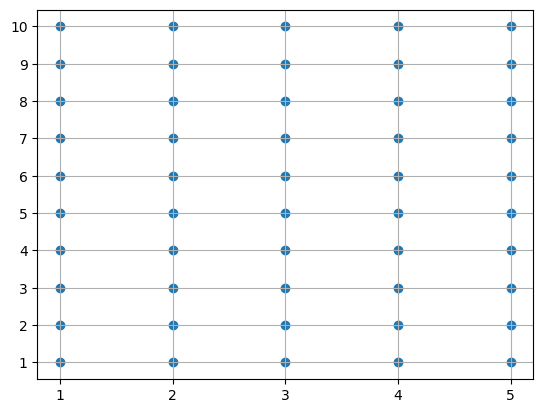

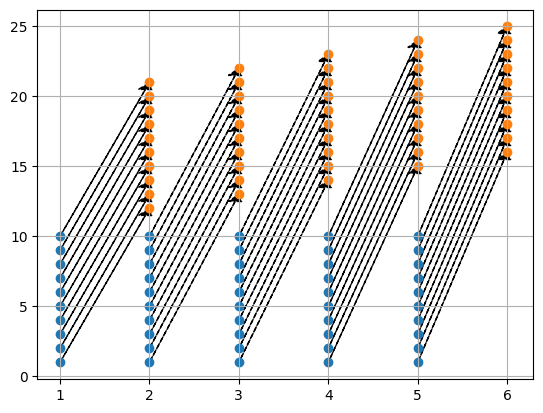

In [2]:
context = isl.Set("{ : }")
domain = isl.Set("{ S[t,i] : 1 <=t<=5 and 1<=i<=10 }")
schedule = isl.Map("{ S[t,i] -> T[t+1,i+t+10] }")

schedule_domain = schedule.intersect_domain(domain)

plot_usets(get_set_list(domain))
plot_umaps(get_umap_list(schedule_domain))

## Translate polyhedral program description to an AST

The AST that is generated is an actual AST. It can be walked and inspected using tree operations.

In [3]:
build = isl.AstBuild.from_context(context) 
ast = build.node_from_schedule_map(schedule.intersect_domain(domain))
print_code(ast)

for (int c0 = 2; c0 <= 6; c0 += 1)
  for (int c1 = c0 + 10; c1 <= c0 + 19; c1 += 1)
    S(c0 - 1, -c0 + c1 - 9);



## AST Generation for Constraint Sets

When optimizing programs some transformations are often only valid
under certain conditions. To still apply such transformations it is
common to perform code versioning. The optimized version of the code is
executed if the conditions hold, an unoptimized version
of the code is executed otherwise.

A simple example could be:
    
```
void foo(long n, A[][100]) {
  for (i = 0; i < n; i++)
    for (j = 0; j < n; j++)
      A[i][j] += i+j;
}
```
This code only has simple dependences if j is smaller than 100. This
means n < 100. Hence we probably want to generate the following code:

```    
void foo(long n, A[][100]) {
  if (n < 100)
    // optimized code
  else
    // otherwise
}
```
The isl AST generator allows for the generation of arbitrary
boolean conditions from a constraint set described by an isl set.

## A simple constraint set

In [5]:
condition = isl.Set("[n] -> {: n < 100}")
expr = build.expr_from_set(condition)
print(expr.to_C_str())

n <= 99


## Recovery of modulo expressions


In [6]:
condition = isl.Set("[n, m] -> {: n % 100 = 2}")
expr = build.expr_from_set(condition)
print(expr.to_C_str())

(n - 2) % 100 == 0


## Verification of complex conditions

In [7]:
condition = isl.Set("[n, m] -> {: (n != 0 implies m = 5) or n + m = 42}")
expr = build.expr_from_set(condition)
print(expr.to_C_str())

m == 5 || n == 0 || n + m == 42
